In [32]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import cosine_similarity

Step 1: Loading the data

In [33]:
# Load the datasets
books = pd.read_csv("https://raw.githubusercontent.com/Uriel-Gamez98/Data-Science-and-Machine-Learning/refs/heads/main/items.csv")
interactions = pd.read_csv("https://raw.githubusercontent.com/Uriel-Gamez98/Data-Science-and-Machine-Learning/refs/heads/main/interactions_train.csv")
# Display the first rows of each dataset
display(books.head())
display(interactions.head())


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


In [34]:
# Renaming columns for clarity
interactions.rename(columns={'u': 'user_id'}, inplace=True)
interactions.rename(columns={'i': 'book_id'}, inplace=True)
interactions.rename(columns={'t': 'timestamp'}, inplace=True)
books.rename(columns={'i': 'book_id'}, inplace=True)

# Checking the new columns
display(interactions.head())
display(books.head())

,user_id,book_id,timestamp
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


Step 2: Check the Number of Interactions, Users and Books

In [35]:
n_users = interactions.user_id.nunique()
n_books = interactions.book_id.nunique()
print(f'Number of users = {n_users}, \n Number of items = {n_books} \n Number of interactions = {len(interactions)}')

Number of users = 7838, 
 Number of items = 15109 
 Number of interactions = 87047


Step 3: Split the Data into Training and Test Sets

In [36]:
# let's first sort the interactions by user and time stamp
interactions = interactions.sort_values(["user_id", "timestamp"])
interactions.head(10)

,user_id,book_id,timestamp
21035,0,0,1.680191e+09
28842,0,1,1.680783e+09
3958,0,2,1.680801e+09
29592,0,3,1.683715e+09
6371,0,3,1.683715e+09
41220,0,4,1.686569e+09
12217,0,5,1.687014e+09
19703,0,6,1.687014e+09
64522,0,7,1.687014e+09
29380,0,8,1.687260e+09


In [37]:
interactions["pct_rank"] = interactions.groupby("user_id")["timestamp"].rank(pct=True, method='dense')
interactions.reset_index(inplace=True, drop=True)
interactions.head(10)

,user_id,book_id,timestamp,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


In [38]:
train_data = interactions[interactions["pct_rank"] < 0.8]
test_data = interactions[interactions["pct_rank"] >= 0.8]
print("Training set size:", train_data.shape[0])
print("Testing set size:", test_data.shape[0])

Training set size: 65419
Testing set size: 21628


Task 2: Creating User-Book Matrices for Implicit Feedback

In [90]:
print('number of users =', n_users, '| number of books =', n_books)

number of users = 7838 | number of books = 15109


Step 1: Define the Function to Create the Data Matrix

In [ ]:
import numpy as np

# Define a function to create the data matrix (1ST ATTEMPT)
def create_data_matrix(data, n_users, n_books):
    """
    This function returns a numpy matrix with shape (n_users, n_items).
    Each entry is a binary value indicating positive interaction.
    """
    data_matrix = np.zeros((n_users, n_books))
    data_matrix[data["user_id"].values, data["book_id"].values] = 1
    return data_matrix

    # Subtract 1 from item_id values to adjust for 0-based indexing
    # Ensure item_id values are within the valid range
    # valid_item_ids = data["item_id"][data["item_id"] <= n_items].values -1
    # valid_user_ids = data["user_id"][data["item_id"] <= n_items].values
    # data_matrix[valid_user_ids, valid_item_ids] = 1

    # return data_matrix

In [111]:
# Define a function to create the data matrix (2ND ATTEMPT)
def create_data_matrix(data, n_users, n_books):
    """
    This function returns a numpy matrix with shape (n_users, n_items).
    Each entry is a binary value indicating positive interaction.
    """
    data_matrix = np.zeros((n_users, n_books))
    for user_id, book_id in data:
        if 0 <= user_id < n_users and 0 <= book_id < n_books:
            data_matrix[user_id, book_id] = 1
    return data_matrix

Step 2: Create the Training and Testing Matrices

In [112]:
# Create the training and testing matrices
train_data_matrix = create_data_matrix(train_data, n_users, n_books)
test_data_matrix = create_data_matrix(test_data, n_users, n_books)

# Display the matrices to understand their structure
print('train_data_matrix')
print(train_data_matrix)
print("number of non-zero values: ", np.sum(train_data_matrix))
print('test_data_matrix')
print(test_data_matrix)
print("number of non-zero values: ", np.sum(test_data_matrix))

train_data_matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  49461.0
test_data_matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  19297.0


Step 3: Visualize the User-Item Interaction Matrices

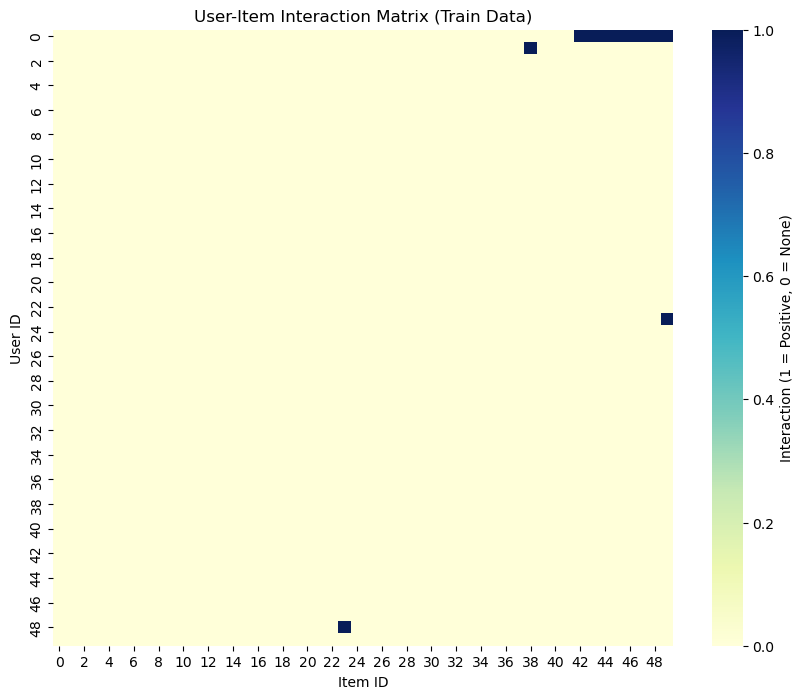

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot a heatmap for a subset of the user-item matrix
def plot_interaction_heatmap(data_matrix, title, num_users=50, num_items=50):
    """
    Plots a heatmap of a subset of the user-item interaction matrix.
    Parameters:
        data_matrix: The matrix to visualize.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization purposes
    matrix_subset = data_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Interaction (1 = Positive, 0 = None)'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the training and testing matrices
plot_interaction_heatmap(train_data_matrix, 'User-Item Interaction Matrix (Train Data)')

Task 3: Item-to-Item Collaborative Filtering with Implicit Feedback

In [122]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the item-item similarity matrix
# Check sklearn documentation for cosine similarity to understand how we are
# using this function.
item_similarity = cosine_similarity(train_data_matrix.T)
print("Item-Item Similarity Matrix:")
print(item_similarity)
print(item_similarity.shape)

Item-Item Similarity Matrix:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(15109, 15109)


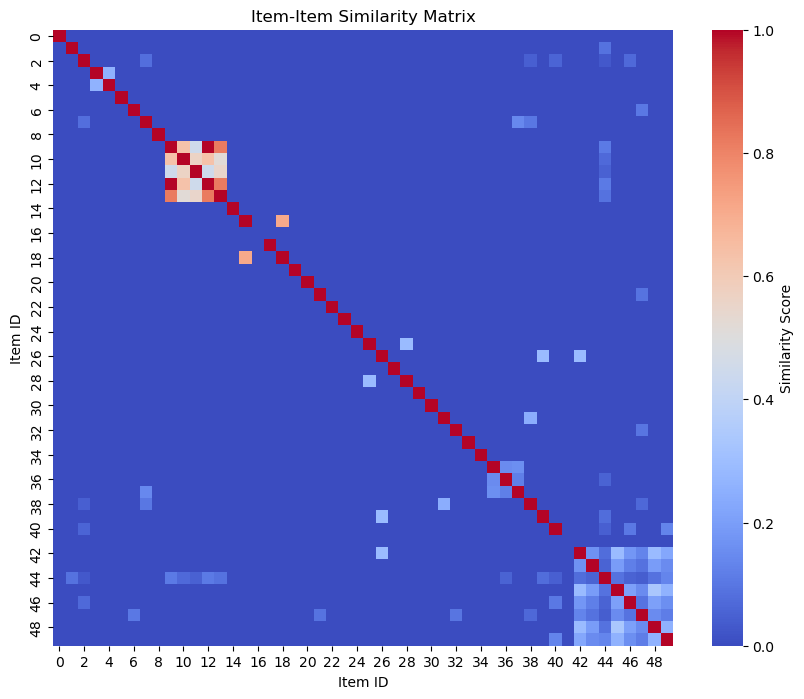

In [123]:
# Function to visualize the item similarity matrix
def plot_item_similarity_heatmap(similarity_matrix, title, num_items=50):
    """
    Plots a heatmap of a subset of the item similarity matrix.
    Parameters:
        similarity_matrix: The item-item similarity matrix.
        title: The title of the plot.
        num_items: The number of items to display (both rows and columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_items, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('Item ID')
    plt.ylabel('Item ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the item similarity matrix
plot_item_similarity_heatmap(item_similarity, 'Item-Item Similarity Matrix')

In [133]:
item_similarity[12, 9]

0.9999999999999998

In [136]:
# Print the item with ID 12
display(books[books['book_id'] == 12])
# Print the item with ID 9
display(books[books['book_id'] == 9])

,Title,Author,ISBN Valid,Publisher,Subjects,book_id
12,L'apprentissage par projets au secondaire : gu...,"Larmer, John",9782765033202; 276503320X,Chenelière éducation,apprentissage (psychologie)--enseignement seco...,12


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
9,Le mirage de la croissance verte /,"Auffret, Anthony",9782413043591; 2413043594,Delcourt,Développement économique--Aspect environnement...,9


In [128]:
# From the item similarity matrix, find the most similar items to a given item
def get_most_similar_items(item_id, similarity_matrix, n=5):
    """
    Returns the most similar items to a given item based on the similarity matrix.
    Parameters:
        item_id: The ID of the item for which to find similar items.
        similarity_matrix: The item-item similarity matrix.
        n: The number of similar items to return.
    Returns:
        A list of tuples containing item IDs and their similarity scores.
    """
    # Get the similarity scores for the given item
    similarity_scores = similarity_matrix[item_id]
    
    # Get the indices of the most similar items
    similar_items_indices = np.argsort(similarity_scores)[::-1][:n]
    
    # Create a list of tuples (item_id, similarity_score)
    similar_items = [(i, similarity_scores[i]) for i in similar_items_indices]
    
    return similar_items

In [129]:
# Example usage
item_id = 19
similar_items = get_most_similar_items(item_id, item_similarity, n=5)
print(f"Most similar items to item {item_id}:")
for item, score in similar_items:
    print(f"Item ID: {item}, Similarity Score: {score}")

Most similar items to item 19:
Item ID: 13477, Similarity Score: 1.0
Item ID: 19, Similarity Score: 1.0
Item ID: 13416, Similarity Score: 0.7071067811865475
Item ID: 7944, Similarity Score: 0.4082482904638631
Item ID: 624, Similarity Score: 0.2886751345948129


In [132]:
# Print the suggested items
display(books[books["book_id"] == 13477])
display(books[books["book_id"] == 19])
display(books[books["book_id"] == 13416])
display(books[books["book_id"] == 7944])

,Title,Author,ISBN Valid,Publisher,Subjects,book_id
13477,"Mathématique, troisième année : méthodologie, ...",NaN,NaN,Librairie de l'Etat de Berne,NaN,13477


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
19,Pays-Bas,NaN,9782067257863; 2067257862,Michelin,Pays-Bas; Guides touristiques et de visite,19


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
13416,"Amour et merveille : les ""Lais"" de Marie de Fr...",NaN,2852037181; 9782852037182,Diff Slatkine; H Champion,"Marie--(de France).--""Lais""--[études diverses]",13416


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
7944,Une histoire de l'homosexualité /,NaN,2020881357; 9782020881357,Seuil,homosexualité--Antiquité / 21e s. (début),7944


In [139]:
# Print the item with ID 46
display(books[books['book_id'] == 46])

# Print the item with ID 37
display(books[books['book_id'] == 37])

,Title,Author,ISBN Valid,Publisher,Subjects,book_id
46,Le monde sans fin /,"Jancovici, Jean-Marc",9782205088168; 2205088165,Dargaud,Climate Change; Environmental Health; Environm...,46


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
37,"Simenon, l'Ostrogoth /","Bocquet, José-Louis",9782505120094; 2505120099; 9782505120100; 2505...,Dargaud,"Bandes dessinées; Simenon, Georges",37


Step 2: Predict Positive Interactions Using Item Similarity

In [141]:
import numpy as np

# Define the function to predict interactions based on item similarity
def item_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Predicts user-item interactions based on item-item similarity.
    Parameters:
        interactions (numpy array): The user-item interaction matrix.
        similarity (numpy array): The item-item similarity matrix.
        epsilon (float): Small constant added to the denominator to avoid division by zero.
    Returns:
        numpy array: The predicted interaction scores for each user-item pair.
    """
    # np.dot does the matrix multiplication. Here we are calculating the
    # weighted sum of interactions based on item similarity
    pred = similarity.dot(interactions.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T  # Transpose to get users as rows and items as columns

# Calculate the item-based predictions for positive interactions
item_prediction = item_based_predict(train_data_matrix, item_similarity)
print("Predicted Interaction Matrix:")
print(item_prediction)
print(item_prediction.shape)

Predicted Interaction Matrix:
[[0.         0.01964735 0.00252954 ... 0.         0.         0.        ]
 [0.         0.04382486 0.01006033 ... 0.         0.         0.        ]
 [0.         0.         0.00134771 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7838, 15109)


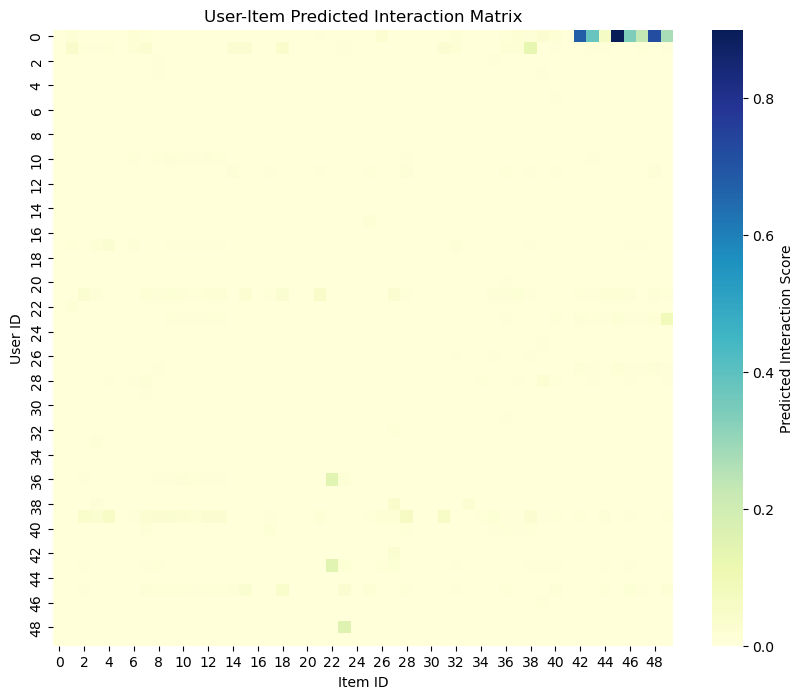

In [142]:
# Function to visualize the predicted interaction matrix for a subset of users and items
def plot_interaction_prediction_heatmap(prediction_matrix, title, num_users=50, num_items=50):
    """
    Plots a heatmap of a subset of the user-item predicted interaction matrix.
    Parameters:
        prediction_matrix: The predicted interaction matrix.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = prediction_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Predicted Interaction Score'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the predicted interaction matrix
plot_interaction_prediction_heatmap(item_prediction, 'User-Item Predicted Interaction Matrix')

Task 4: User-to-User Collaborative Filtering with Implicit Feedback

In [143]:
# Compute the user-user similarity matrix
user_similarity = cosine_similarity(train_data_matrix)
print("User-User Similarity Matrix:")
print(user_similarity)

# Check the shape as a sanity check
print("Shape of User Similarity Matrix:", user_similarity.shape)

User-User Similarity Matrix:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of User Similarity Matrix: (7838, 7838)


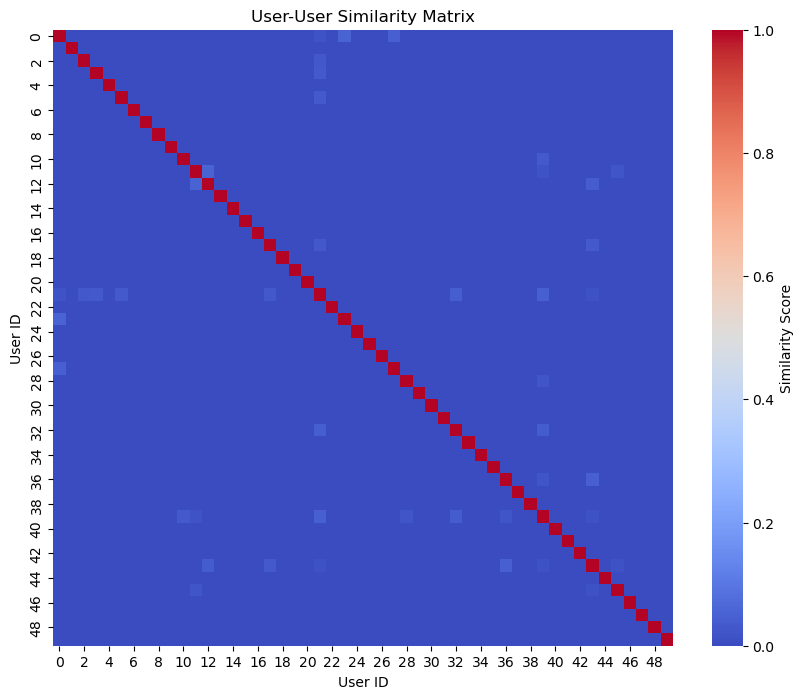

In [147]:
# Function to plot the user similarity matrix
def plot_user_similarity_heatmap(similarity_matrix, title, num_users=50):
    """
    Plots a heatmap of a subset of the user similarity matrix.
    Parameters:
        similarity_matrix: The user-user similarity matrix.
        title: The title of the plot.
        num_users: The number of users to display (both rows and columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_users, :num_users]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('User ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the user similarity matrix
plot_user_similarity_heatmap(user_similarity, 'User-User Similarity Matrix')

In [148]:
# Define the function to predict interactions based on user similarity
def user_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Predicts user-item interactions based on user-user similarity.
    Parameters:
        interactions (numpy array): The user-item interaction matrix.
        similarity (numpy array): The user-user similarity matrix.
        epsilon (float): Small constant added to the denominator to avoid division by zero.
    Returns:
        numpy array: The predicted interaction scores for each user-item pair.
    """
    # Calculate the weighted sum of interactions based on user similarity
    pred = similarity.dot(interactions) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon)
    return pred

# Calculate the user-based predictions for positive interactions
user_prediction = user_based_predict(train_data_matrix, user_similarity)
print("Predicted Interaction Matrix (User-Based):")
print(user_prediction)
print(user_prediction.shape)

Predicted Interaction Matrix (User-Based):
[[0.         0.00516441 0.00611098 ... 0.         0.         0.        ]
 [0.         0.00596982 0.02404238 ... 0.         0.         0.        ]
 [0.         0.         0.01048962 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7838, 15109)


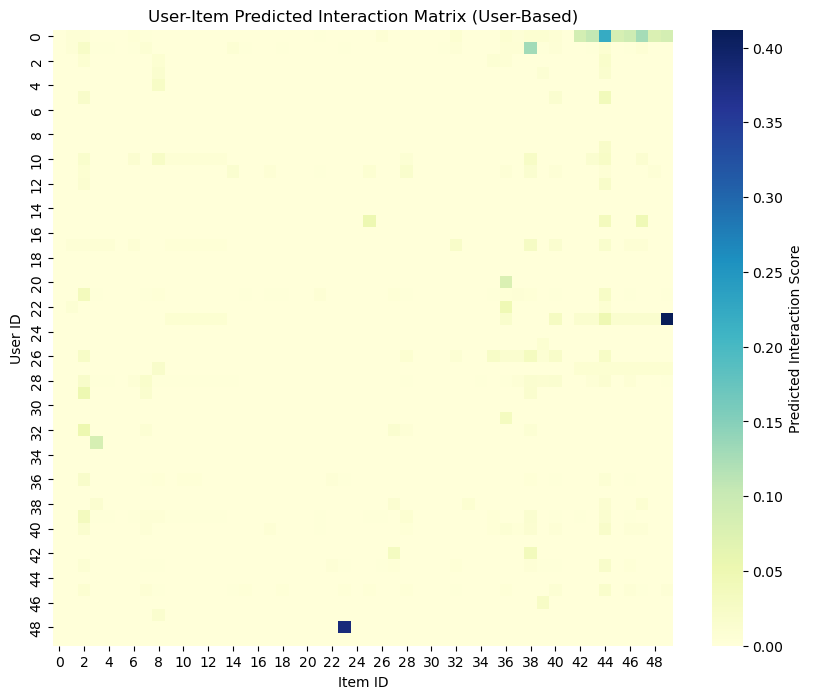

In [149]:
# Function to visualize the predicted interaction matrix for a subset of users and items
def plot_interaction_prediction_heatmap(prediction_matrix, title, num_users=50, num_items=50):
    """
    Plots a heatmap of a subset of the user-item predicted interaction matrix.
    Parameters:
        prediction_matrix: The predicted interaction matrix.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = prediction_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Predicted Interaction Score'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the predicted interaction matrix
plot_interaction_prediction_heatmap(user_prediction, 'User-Item Predicted Interaction Matrix (User-Based)')

Task 5: Evaluating our recommender

In [150]:
#TODO: Implement the precision_recall_at_k function

def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k = 0, 0

    for user in range(num_users):
        # TODO: Get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]
        
        # TODO: Calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.isin(top_k_items, np.where(ground_truth[user, :] == 1)[0]).sum()
        
        # TODO: Calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()
        
        # Precision@K and Recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

    # Average Precision@K and Recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users
    
    return precision_at_k, recall_at_k

In [151]:
# Run this line after implementing the function
precision_user_k, recall_user_k = precision_recall_at_k(user_prediction, test_data_matrix, k=10)
precision_item_k, recall_item_k = precision_recall_at_k(item_prediction, test_data_matrix, k=10)

print('User-based CF Precision@K:', precision_user_k)
print('User-based CF Recall@K:', recall_user_k)
print('Item-based CF Precision@K:', precision_item_k)
print('Item-based CF Recall@K:', recall_item_k)

User-based CF Precision@K: 0.05591987751977813
User-based CF Recall@K: 0.2867094186891897
Item-based CF Precision@K: 0.05506506761929339
Item-based CF Recall@K: 0.261140155818284


Task 6: Show the recommendations for a specific user

In [152]:
import random
import numpy as np

# Pick a user at random
user_id = random.choice(range(user_prediction.shape[0]))
print("Selected User ID:", user_id)

# Get top-10 recommendations for the user from User-to-User CF
user_top_10 = np.argsort(user_prediction[user_id, :])[-10:][::-1]

# Get top-10 recommendations for the user from Item-to-Item CF
item_top_10 = np.argsort(item_prediction[user_id, :])[-10:][::-1]

# Display top-10 recommended movie IDs for both models
display(user_top_10)
display(item_top_10)

Selected User ID: 6167


array([  578,  2746, 11459,  2101,  2947,  2105,   577,  3700,   767,
         579])

array([ 2105, 11459,  2947,   575,  2746, 13069,  1326,   578,  9067,
        6641])

In [156]:
# Convert user_top_10 and item_top_10 arrays into DataFrames
user_top_10_df = pd.DataFrame({'book_id': user_top_10})
item_top_10_df = pd.DataFrame({'book_id': item_top_10})

# Merge with movies_df to add the title column
user_recommendations_df = user_top_10_df.merge(books[['book_id', 'Title']], left_on='book_id', right_on='book_id')
item_recommendations_df = item_top_10_df.merge(books[['book_id', 'Title']], left_on='book_id', right_on='book_id')

# Select only the columns we want to display
user_recommendations_df = user_recommendations_df[['book_id', 'Title']]
item_recommendations_df = item_recommendations_df[['book_id', 'Title']]

# Display the results
display(user_recommendations_df)
display(item_recommendations_df)

,book_id,Title
0,578,Réinventer l'amour : comment le patriarcat sab...
1,2746,Auto-efficacité : comment le sentiment d'effi...
2,11459,Nous les menteurs /
3,2101,So shall you reap /
4,2947,Recherche et méthodologie en sciences humaines /
5,2105,Le naufrage de Venise : roman /
6,577,L'amour /
7,3700,Mai 67 /
8,767,Espèces d'espaces /
9,579,Le bon père /


,book_id,Title
0,2105,Le naufrage de Venise : roman /
1,11459,Nous les menteurs /
2,2947,Recherche et méthodologie en sciences humaines /
3,575,Les formes du visible : une anthropologie de l...
4,2746,Auto-efficacité : comment le sentiment d'effi...
5,13069,Manger au Moyen Âge : pratiques et discours al...
6,1326,Soins infirmiers en gériatrie : vieillissement...
7,578,Réinventer l'amour : comment le patriarcat sab...
8,9067,Les aiguilles d'or : roman /
9,6641,L'oiseau qui buvait du lait : roman /


In [157]:
# Generating a csv file with the top 10 recommendations for each user_id
def generate_recommendations(prediction_matrix, books_df, n=10):
    """
    Generates top-N recommendations for each user based on the prediction matrix.
    Parameters:
        prediction_matrix (numpy array): The predicted interaction matrix.
        books_df (DataFrame): DataFrame containing book information.
        n (int): Number of top recommendations to generate for each user.
    Returns:
        DataFrame: A DataFrame containing user_id and their top-N recommended book_ids.
    """
    recommendations = []
    
    for user_id in range(prediction_matrix.shape[0]):
        # Get the indices of the top-N items for the user based on predicted scores
        top_n_items = np.argsort(prediction_matrix[user_id, :])[-n:][::-1]
        
        # Append the user_id and recommended item_ids to the list
        recommendations.append((user_id, list(top_n_items)))
    
    # Convert to DataFrame
    recommendations_df = pd.DataFrame(recommendations, columns=['user_id', 'recommended_items'])
    
    # Explode the list of recommended items into separate rows
    recommendations_df = recommendations_df.explode('recommended_items')
    
    # Merge with books_df to get book titles
    recommendations_df = recommendations_df.merge(books_df[['book_id', 'Title']], left_on='recommended_items', right_on='book_id', how='left')
    
    return recommendations_df[['user_id', 'recommended_items', 'Title']]
# Generate recommendations for the user-based model
user_recommendations_df = generate_recommendations(user_prediction, books, n=10)
# Generate recommendations for the item-based model
item_recommendations_df = generate_recommendations(item_prediction, books, n=10)
# Save to CSV files
user_recommendations_df.to_csv('user_based_recommendations.csv', index=False)
item_recommendations_df.to_csv('item_based_recommendations.csv', index=False)
# Display the first few rows of the user-based recommendations
display(user_recommendations_df.head())
# Display the first few rows of the item-based recommendations
display(item_recommendations_df.head())

,user_id,recommended_items,Title
0,0,44,Tokyo tarareba girls /
1,0,56,Soixante printemps en hiver /
2,0,51,Le bébé des Buttes-Chaumont /
3,0,47,La Fille à la moto /
4,0,54,Pil /


,user_id,recommended_items,Title
0,0,78,Fullmetal alchemist /
1,0,74,Turing à la plage : l'intelligence artificiell...
2,0,45,Yotsuba & ! /
3,0,77,Ici /
4,0,70,Fudafudak : l'endroit qui scintille /


In [160]:
# Get top-10 recommendations for all the users from User-to-User CF
# Get top-10 recommendations for all the users from Item-to-Item CF
user_top_10 = np.argsort(user_prediction, axis=1)[:, -10:][:, ::-1]  # Get top-10 recommendations for the user from User-to-User CF for all users
item_top_10 = np.argsort(item_prediction, axis=1)[:, -10:][:, ::-1]  # Get top-10 recommendations for the user from Item-to-Item CF for all users
# Convert user_top_10 and item_top_10 arrays into DataFrames
user_top_10_df = pd.DataFrame(user_top_10, columns=[f'Top_{i+1}' for i in range(10)])
item_top_10_df = pd.DataFrame(item_top_10, columns=[f'Top_{i+1}' for i in range(10)])

# Display top-10 recommended movie IDs for both models
display(user_top_10)
display(item_top_10)

array([[   44,    56,    51, ...,    73,    43,    65],
       [  147,    38,   136, ...,   154,   131,   137],
       [  200,   196,   189, ...,   194,   197,   193],
       ...,
       [   86,  2189,  3375, ...,  7135,  1160,  4899],
       [15108,  5030,  5042, ...,  5037,  5036,  5035],
       [15108,  5030,  5042, ...,  5037,  5036,  5035]])

array([[   78,    74,    45, ...,    71,    42,    55],
       [  132,   155,   148, ...,   153,   149,   145],
       [  190,   202,   200, ...,   192,   194,   195],
       ...,
       [10540,  2189,    86, ..., 13409,  9494,  6302],
       [15108,  5030,  5042, ...,  5037,  5036,  5035],
       [15108,  5030,  5042, ...,  5037,  5036,  5035]])

In [208]:
# For all the users, get the top-10 recommendations from User-to-User CF
# For all the users, get the top-10 recommendations from Item-to-Item CF
user_top_10 = np.argsort(user_prediction, axis=1)[:, -10:][:, ::-1]  # Get top-10 recommendations for the user from User-to-User CF for all users
item_top_10 = np.argsort(item_prediction, axis=1)[:, -10:][:, ::-1]  # Get top-10 recommendations for the user from Item-to-Item CF for all users
# Convert user_top_10 and item_top_10 arrays into DataFrames
user_top_10_df = pd.DataFrame(user_top_10, columns=[f'Top_{i+1}' for i in range(10)])
item_top_10_df = pd.DataFrame(item_top_10, columns=[f'Top_{i+1}' for i in range(10)])
print(user_top_10_df)
print(item_top_10_df)


      Top_1  Top_2  Top_3  Top_4  Top_5  Top_6  Top_7  Top_8  Top_9  Top_10
0        44     56     51     47     54     80     62     73     43      65
1       147     38    136    153    126    140    141    154    131     137
2       200    196    189    201    191    199    195    194    197     193
3       214    215    210    219    213    216    218    217    212     211
4       229    228    227  10865   6068  13948   5155   3423   4946    1114
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...
7833   3053   4818  11124   1365     51     43   3017   8997   2123    8365
7834  14548   3469   8997    609  14553  14555  10912   7113   1395   14558
7835     86   2189   3375   9667   6971  10540   3897   7135   1160    4899
7836  15108   5030   5042   5041   5040   5039   5038   5037   5036    5035
7837  15108   5030   5042   5041   5040   5039   5038   5037   5036    5035

[7838 rows x 10 columns]
      Top_1  Top_2  Top_3  Top_4  Top_5  Top_6  Top_7  Top_8  

In [209]:
# For both models, concatenate the top-10 recommendations for each user separating by a space
user_top_10_df['Top_Recommendations'] = user_top_10_df.apply(lambda x: ' '.join(map(str, x)), axis=1)
item_top_10_df['Top_Recommendations'] = item_top_10_df.apply(lambda x: ' '.join(map(str, x)), axis=1)
# Display the top-10 recommendations for both models
display(user_top_10_df[['Top_Recommendations']])
display(item_top_10_df[['Top_Recommendations']])

,Top_Recommendations
0,44 56 51 47 54 80 62 73 43 65
1,147 38 136 153 126 140 141 154 131 137
2,200 196 189 201 191 199 195 194 197 193
3,214 215 210 219 213 216 218 217 212 211
4,229 228 227 10865 6068 13948 5155 3423 4946 1114
...,...
7833,3053 4818 11124 1365 51 43 3017 8997 2123 8365
7834,14548 3469 8997 609 14553 14555 10912 7113 139...
7835,86 2189 3375 9667 6971 10540 3897 7135 1160 4899
7836,15108 5030 5042 5041 5040 5039 5038 5037 5036 ...


,Top_Recommendations
0,78 74 45 77 70 50 48 71 42 55
1,132 155 148 130 143 138 114 153 149 145
2,190 202 200 201 193 198 189 192 194 195
3,210 219 216 211 217 215 11648 213 212 9607
4,227 229 6504 228 10865 1629 7720 9187 12979 3857
...,...
7833,13014 6221 6315 9955 4818 3053 14873 5515 3741...
7834,14548 14555 14558 14616 11818 3469 14849 10912...
7835,10540 2189 86 1160 9186 3375 3606 13409 9494 6302
7836,15108 5030 5042 5041 5040 5039 5038 5037 5036 ...


In [210]:
# Create a new dataframe that contains the user_id and the top-10 recommendations
user_recommendations_df = pd.DataFrame({'user_id': range(user_top_10.shape[0]), 'Top_Recommendations': user_top_10_df['Top_Recommendations']})
item_recommendations_df = pd.DataFrame({'user_id': range(item_top_10.shape[0]), 'Top_Recommendations': item_top_10_df['Top_Recommendations']})
# Display the first few rows of the user-based recommendations
display(user_recommendations_df.head())
# Display the first few rows of the item-based recommendations
display(item_recommendations_df.head())
# Save the recommendations to CSV files
user_recommendations_df.to_csv('user_based_recommendations.csv', index=False)
item_recommendations_df.to_csv('item_based_recommendations.csv', index=False)

,user_id,Top_Recommendations
0,0,44 56 51 47 54 80 62 73 43 65
1,1,147 38 136 153 126 140 141 154 131 137
2,2,200 196 189 201 191 199 195 194 197 193
3,3,214 215 210 219 213 216 218 217 212 211
4,4,229 228 227 10865 6068 13948 5155 3423 4946 1114


,user_id,Top_Recommendations
0,0,78 74 45 77 70 50 48 71 42 55
1,1,132 155 148 130 143 138 114 153 149 145
2,2,190 202 200 201 193 198 189 192 194 195
3,3,210 219 216 211 217 215 11648 213 212 9607
4,4,227 229 6504 228 10865 1629 7720 9187 12979 3857
